In [8]:
import os
import shutil
import random
from pathlib import Path

# Base data directory
base_dir = Path('/Users/tehreem/Desktop/Study/Projects/SDS-CP028-smart-leaf/submissions/team-members/tehreem-ansari/data')
source_dir = base_dir / 'ValidCrops'
target_dirs = {
    'train': base_dir / 'train',
    'val': base_dir / 'val',
    'test': base_dir / 'test'
}

# Create target dirs
for split_dir in target_dirs.values():
    os.makedirs(split_dir, exist_ok=True)

# Function to get all image file paths
def get_images(path):
    return [file for file in path.iterdir() if file.is_file() and file.suffix.lower() in ['.jpg', '.jpeg', '.png']]

# Walk through each category (corn, rice, etc.)
for crop_folder in source_dir.iterdir():
    if crop_folder.is_dir():
        for disease_folder in crop_folder.iterdir():
            if disease_folder.is_dir():
                images = get_images(disease_folder)
                random.shuffle(images)

                # Split images
                total = len(images)
                train_end = int(0.8 * total)
                val_end = int(0.9 * total)

                split_data = {
                    'train': images[:train_end],
                    'val': images[train_end:val_end],
                    'test': images[val_end:]
                }

                # Copy images to new folders
                class_name = disease_folder.name
                for split, image_list in split_data.items():
                    class_dir = target_dirs[split] / class_name
                    os.makedirs(class_dir, exist_ok=True)
                    for image_path in image_list:
                        shutil.copy(image_path, class_dir / image_path.name)

print("Data split and copied successfully.")


Data split and copied successfully.


In [11]:
import tensorflow as tf

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels="inferred",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=val_dir,
    labels="inferred",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels="inferred",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)


Found 10414 files belonging to 14 classes.
Found 1301 files belonging to 14 classes.
Found 1309 files belonging to 14 classes.


In [12]:
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy', 'Corn___Northern_Leaf_Blight', 'Potato___Early_Blight', 'Potato___Healthy', 'Potato___Late_Blight', 'Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast', 'Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']


2025-04-29 16:41:43.091347: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


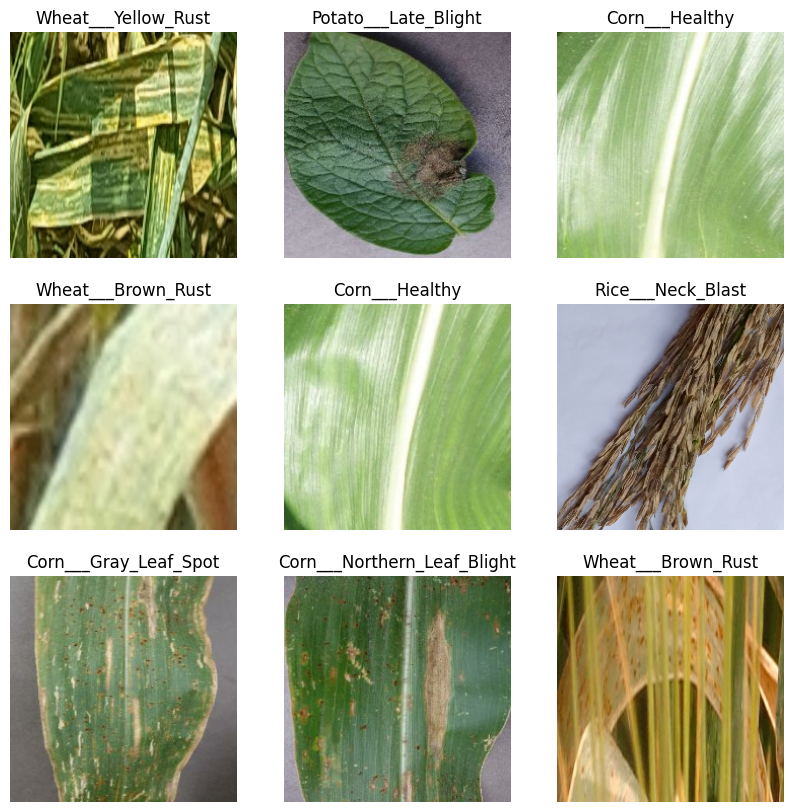

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
plt.show()

In [14]:
# Function to count images in each class
def count_images_in_train(train_dir):
    image_counts = {}
    # Traverse through all class directories in train
    for class_dir in train_dir.iterdir():
        if class_dir.is_dir():
            # Count the images in each class folder
            image_count = len([file for file in class_dir.iterdir() if file.is_file() and file.suffix.lower() in ['.jpg', '.jpeg', '.png']])
            image_counts[class_dir.name] = image_count
    
    return image_counts

# Get image count for each class in train set
image_counts = count_images_in_train(train_dir)

# Print the image count for each class
for class_name, count in image_counts.items():
    print(f"{class_name}: {count} images")


Wheat___Brown_Rust: 721 images
Potato___Early_Blight: 800 images
Wheat___Healthy: 892 images
Potato___Late_Blight: 800 images
Wheat___Yellow_Rust: 739 images
Rice___Healthy: 1190 images
Corn___Northern_Leaf_Blight: 788 images
Rice___Brown_Spot: 490 images
Rice___Leaf_Blast: 781 images
Corn___Common_Rust: 953 images
Corn___Healthy: 929 images
Corn___Gray_Leaf_Spot: 410 images
Rice___Neck_Blast: 800 images
Potato___Healthy: 121 images
